# 1. Data Analysis and Model training

### 1. Logistic Regression

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
#reading data
df = pd.read_csv('data/ICU.csv')
df.head()

,Unnamed: 0,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,1,4,0,87,3,1,1,80,96,1
1,2,8,1,27,1,1,1,142,88,1
2,3,12,1,59,2,0,0,112,80,1
3,4,14,1,77,3,0,0,100,70,0
4,5,27,0,76,3,1,1,128,90,1


In [3]:
#data description
df = df.iloc[:,2:]
df.describe()

,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000
mean,0.800000,57.545000,2.025000,0.380000,0.420000,132.280000,98.92500,0.735000
std,0.401004,20.054648,0.785788,0.486604,0.494797,32.952099,26.82962,0.442441
min,0.000000,16.000000,1.000000,0.000000,0.000000,36.000000,39.00000,0.000000
25%,1.000000,46.750000,1.000000,0.000000,0.000000,110.000000,80.00000,0.000000
50%,1.000000,63.000000,2.000000,0.000000,0.000000,130.000000,96.00000,1.000000
75%,1.000000,72.000000,3.000000,1.000000,1.000000,150.000000,118.25000,1.000000
max,1.000000,92.000000,3.000000,1.000000,1.000000,256.000000,192.00000,1.000000


In [4]:
#checking null data
df.isnull().sum()

Survive      0
Age          0
AgeGroup     0
Sex          0
Infection    0
SysBP        0
Pulse        0
Emergency    0
dtype: int64

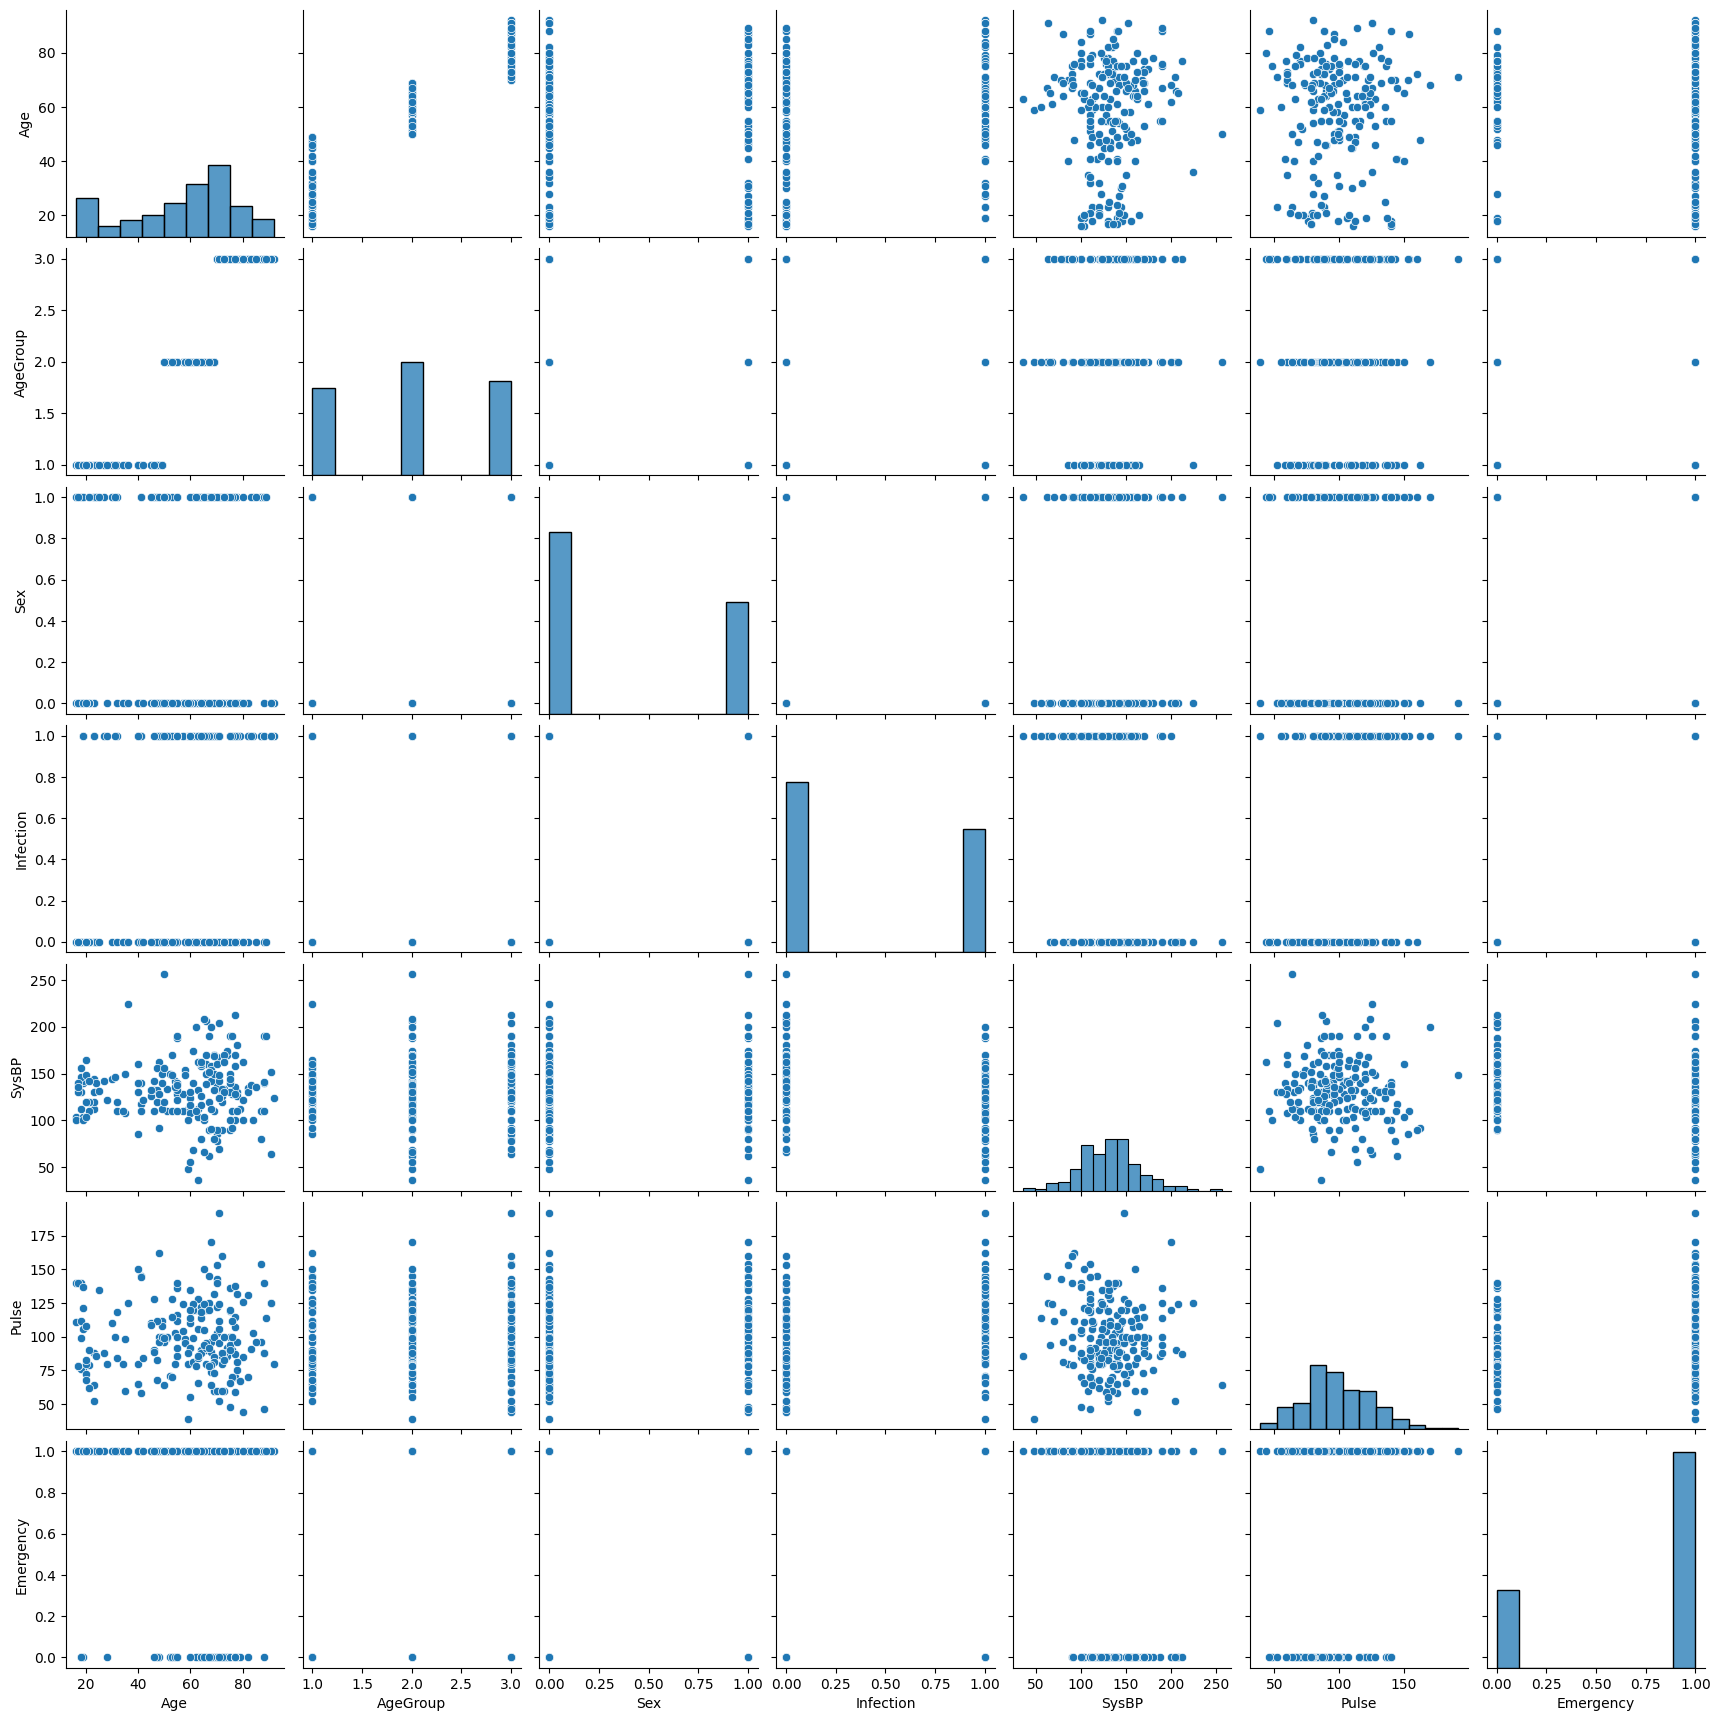

In [5]:
#visualization
sns.pairplot(df.iloc[:,1:])

In [6]:
#splitting train and test set
train_data, test_data, train_target, test_target = train_test_split(
    df.drop('Survive', axis=1), df['Survive'], test_size=0.2, random_state=42
)

In [7]:
#pipeline to transform data and train logistic regression model
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'SysBP','Pulse']),
        ('cat', OneHotEncoder(), ['AgeGroup','Sex','Infection','Emergency'])
    ]
)


log_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
    
])

In [8]:
#validation
log_reg_model.fit(train_data, train_target)
accuracy = log_reg_model.score(test_data, test_target)
print("Accuracy:", accuracy)

Accuracy: 0.85


In [9]:
#fitting all data and train model to be deployed
df_data = df.drop(['Survive'], axis=1)
log_reg_model.fit(df_data, df['Survive'])

joblib.dump(log_reg_model, 'models/log_reg_model.joblib')

['models/log_reg_model.joblib']

### 2. Decision Tree

In [10]:
#train decision tree model
model = DecisionTreeClassifier()

model.fit(train_data, train_target)

accuracy = model.score(test_data,test_target)

print("Accuracy:", accuracy)

Accuracy: 0.65


In [11]:
#grid search and validation
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 4, 6, 8]
}

model = DecisionTreeClassifier()

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(train_data, train_target)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
accuracy = best_model.score(test_data, test_target)
print("Accuracy:", accuracy)

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Accuracy: 0.775


In [12]:
#fitting all data and train model to be deployed

model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2)

model.fit(df_data, df['Survive'])

joblib.dump(log_reg_model, 'models/tree_model.joblib')

['models/tree_model.joblib']

### 3. Random forest

In [13]:
#grid search and validation
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 3, 5, 7, None],
    'min_samples_split': [2, 4, 5, 6, 7]
}

model = RandomForestClassifier()

grid_search = GridSearchCV(model, param_grid, cv=10)

grid_search.fit(train_data, train_target)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
accuracy = best_model.score(test_data, test_target)
print("Accuracy:", accuracy)

Best Parameters: {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 10}
Accuracy: 0.8


In [14]:
#fitting all data and train model to be deployed

model = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=6)

model.fit(df_data, df['Survive'])

joblib.dump(log_reg_model, 'models/rf_model.joblib')

['models/rf_model.joblib']

# 2. Databases

In [15]:
#import required library for this part
import sqlite3

In [16]:
#reading data
data = pd.read_csv('data/ICU.csv')

In [17]:
#normalize data into 2 tables: patients metadata and health record data
patients_df = data[['ID','Age','AgeGroup','Sex']] 
records_df = data[['ID', 'Infection','SysBP', 'Pulse', 'Emergency', 'Survive']]

In [18]:
#create db and establish connection
conn = sqlite3.connect('sgh.db')

#store in two tables under same db
patients_df.to_sql('patients', con=conn, if_exists='replace', index=False)
records_df.to_sql('records', con=conn, if_exists='replace', index=False)

#create empty logging table to store logs of new patients data input
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS logging (
    ID INTEGER,
    Age INTEGER,
    AgeGroup INTEGER,
    Sex INTEGER,
    Infection INTEGER,
    SysBP INTEGER,
    Pulse INTEGER,
    Emergency INTEGER
)
""")

# Commit the changes to the database
conn.commit()

In [19]:
#getting back all record data for every patients if needed
sql_string = '''
            SELECT * FROM patients p 
            LEFT JOIN records r ON p.ID = r.ID 
            '''
            
pd.read_sql(sql_string, con=conn)

,ID,Age,AgeGroup,Sex,ID,Infection,SysBP,Pulse,Emergency,Survive
0,4,87,3,1,4,1,80,96,1,0
1,8,27,1,1,8,1,142,88,1,1
2,12,59,2,0,12,0,112,80,1,1
3,14,77,3,0,14,0,100,70,0,1
4,27,76,3,1,27,1,128,90,1,0
...,...,...,...,...,...,...,...,...,...,...
195,921,50,2,1,921,0,256,64,1,0
196,923,20,1,0,923,0,104,83,1,1
197,924,73,3,1,924,0,162,100,1,1
198,925,59,2,0,925,0,100,88,1,1


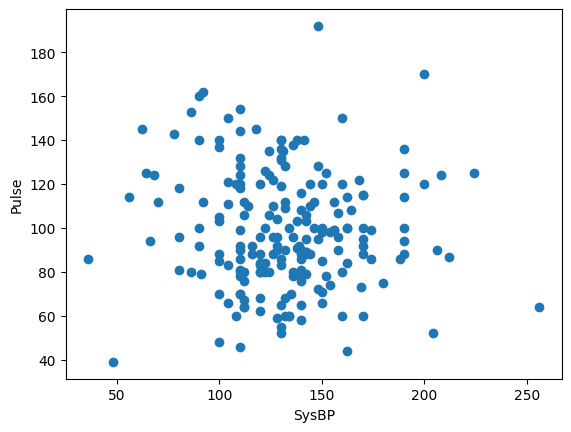

In [20]:
#example: query data required to plot relationships between SysBP and Pulse
sql_string = '''
            SELECT SysBP, Pulse FROM records 
            '''
            
df_plot = pd.read_sql(sql_string, con=conn)

plt.scatter(df_plot['SysBP'], df_plot['Pulse'])
plt.xlabel('SysBP')
plt.ylabel('Pulse')

# Close the connection to the database
conn.close()